In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import sklearn.model_selection
from random import sample
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import math
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Preprocessing

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
40577,00010544_001.png,Infiltration,1,10544,33,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010544_001.png
24032,00006318_012.png,No Finding,12,6318,67,M,PA,2048,2500,0.171,0.171,NaN,/data/images_003/images/00006318_012.png
16587,00004436_003.png,Nodule,3,4436,47,F,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004436_003.png


In [3]:
## create some extra columns in the table with binary indicators of certain diseases 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12464,00003254_000.png,Effusion|Fibrosis|Infiltration,0,3254,55,F,PA,2992,2991,0.143,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90269,00022442_002.png,Edema,2,22442,35,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2206,00000580_007.png,Infiltration|Pleural_Thickening,7,580,61,M,PA,2836,2889,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# Distribution of diseases that are present in both datasets
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

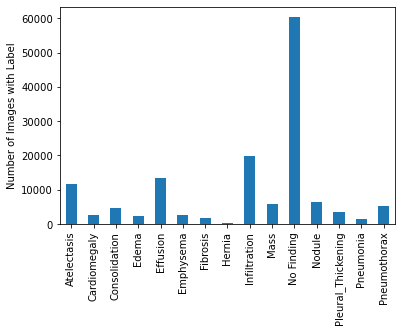

In [5]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

From above it can be seen that the most common occurrence is 'No Fingding' with the probability more than 53%. And this label can never be together with others. Besides that, the most common disease label is 'Infilteration', which followed by 'Effusion' and 'Atelectasis.' And according to the diagramm 'The distribution of other diseases that are comorbid with pneumonia' which showed in EDA, the disease 'Infilteration' occurs most frequently with pneuminia. It is followed by 'Edema' and 'Atelectasis' 


In [6]:
## create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
def cut_off(val):
    if val ==1:
        return 'Pneumonia'
    else:
        return 'No Pneumonia'

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].apply(cut_off)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia


## Create training and testing data

In [7]:
def create_splits(df, stratify):
    train_ds, val_ds = sklearn.model_selection.train_test_split(df,
                                    test_size=0.2,
                                    stratify = stratify)
    return train_ds, val_ds

In [8]:
train_ds, val_ds = create_splits(all_xray_df, stratify=all_xray_df['pneumonia_class'])

In [9]:
# calculate the proportion of each label of training data
train_ds.pneumonia_class.value_counts()/len(train_ds)

No Pneumonia    0.987235
Pneumonia       0.012765
Name: pneumonia_class, dtype: float64

In [10]:
val_ds.pneumonia_class.value_counts()/len(val_ds)

No Pneumonia    0.987246
Pneumonia       0.012754
Name: pneumonia_class, dtype: float64

Text(0.5, 1.0, 'Validation data')

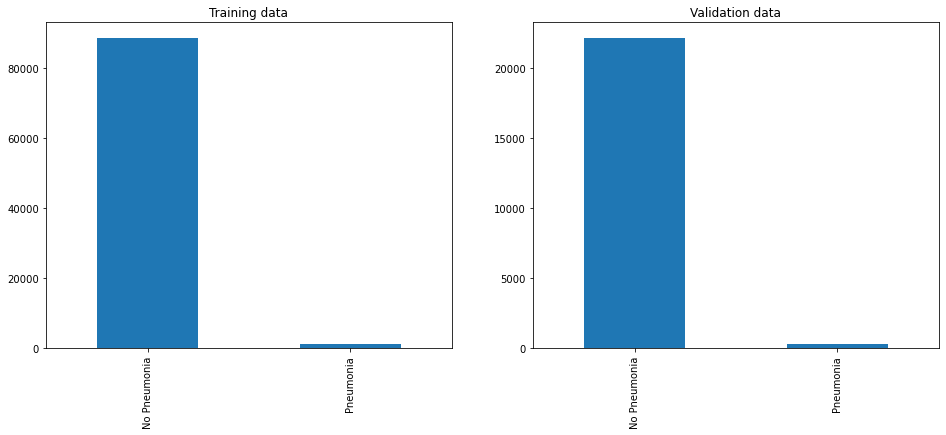

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
train_ds.pneumonia_class.value_counts().plot(kind='bar')
plt.title('Training data')
plt.subplot(1,2,2)
val_ds.pneumonia_class.value_counts().plot(kind='bar')
plt.title('Validation data')

From above it can be seen that both datasets are highly imbalace. In order to have equal amount of positive and negative cases of Pneumonia in Training a operation of downsampling is needed. And validation data should be as realistic as possible

In [12]:
# downsampling of training data
df_class1 = train_ds[train_ds.pneumonia_class=='Pneumonia']
df_class0 = train_ds[train_ds.pneumonia_class=='No Pneumonia']
if len(df_class1) <= len(df_class0):
       df_class0 = df_class0.sample(len(df_class1), replace=True)
else:
       df_class1 = df_class1.sample(len(df_class0), replace=True)
train_ds = pd.concat([df_class1, df_class0], sort=False)

In [13]:
# to checke if the amount of each class is equal
train_ds.pneumonia_class.value_counts()/len(train_ds)

Pneumonia       0.5
No Pneumonia    0.5
Name: pneumonia_class, dtype: float64

In [14]:
# downsampling of training data
p_inds = val_ds[val_ds.pneumonia_class=='Pneumonia'].index.tolist()
np_inds = val_ds[val_ds.pneumonia_class=='No Pneumonia'].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_ds = val_ds.loc[p_inds + np_sample]

In [15]:
# checke the ratio of each class of val data
val_ds.pneumonia_class.value_counts()/len(val_ds)

No Pneumonia    0.8
Pneumonia       0.2
Name: pneumonia_class, dtype: float64

Text(0.5, 1.0, 'Validation data')

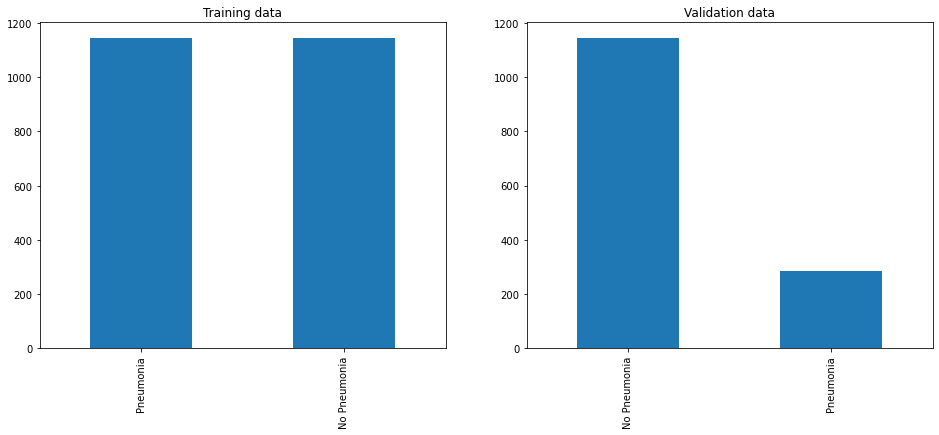

In [16]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
train_ds.pneumonia_class.value_counts().plot(kind='bar')
plt.title('Training data')
plt.subplot(1,2,2)
val_ds.pneumonia_class.value_counts().plot(kind='bar')
plt.title('Validation data')

# Model-building & training

## Perform some image augmentation on the data

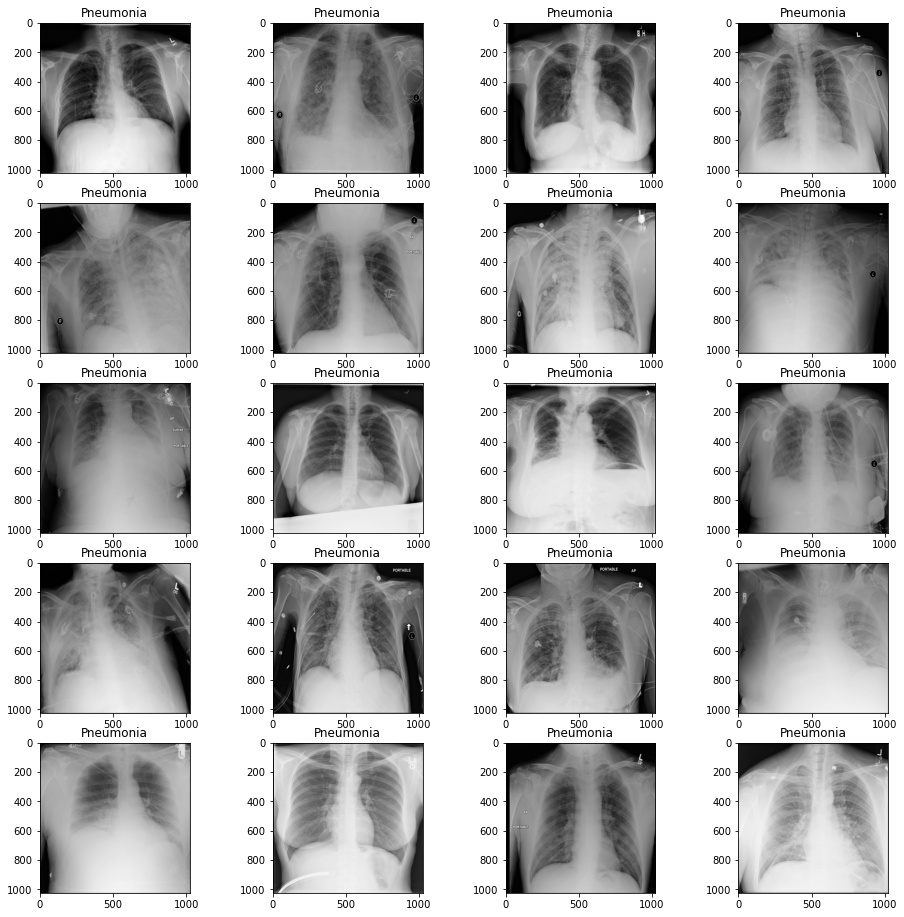

In [17]:
## First to check what the original images look like

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten() 
imgs = train_ds.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_ds.iloc[ind]['pneumonia_class'])
    ind=ind+1

In [18]:
IMG_SIZE = (224, 224)

In [19]:
def my_image_augmentation(train=False):
    
    if train:
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 20, 
                              shear_range = 0.1,
                              zoom_range= 0.2
                              )
    else:
        my_idg = ImageDataGenerator(rescale=1. / 255.0)

    return my_idg


def make_train_gen(train, df, x_col, y_col, class_mode, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for training data
 
    train_gen = my_image_augmentation(train=train).flow_from_dataframe(dataframe=df, 
                                                                       directory=None, 
                                                                       x_col = x_col,
                                                                       y_col = y_col,
                                                                       class_mode = class_mode,
                                                                       target_size = IMG_SIZE, 
                                                                       batch_size = batch_size
                                                                       )
    return train_gen


def make_val_gen(train, df, x_col, y_col, class_mode, batch_size):
    
    val_gen = my_image_augmentation(train=train).flow_from_dataframe(dataframe=df, 
                                                                     directory=None, 
                                                                     x_col = x_col,
                                                                     y_col = y_col,
                                                                     class_mode = class_mode,
                                                                     target_size = IMG_SIZE, 
                                                                     batch_size = batch_size
                                                                     )

    return val_gen

In [20]:
train_gen = make_train_gen(train=True, df=train_ds, x_col='path', y_col='pneumonia_class', class_mode='binary', batch_size=16)

Found 2290 validated image filenames belonging to 2 classes.


In [21]:
val_gen = make_val_gen(train=False, df=val_ds, x_col='path', y_col='pneumonia_class', class_mode='binary', batch_size=128)

Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

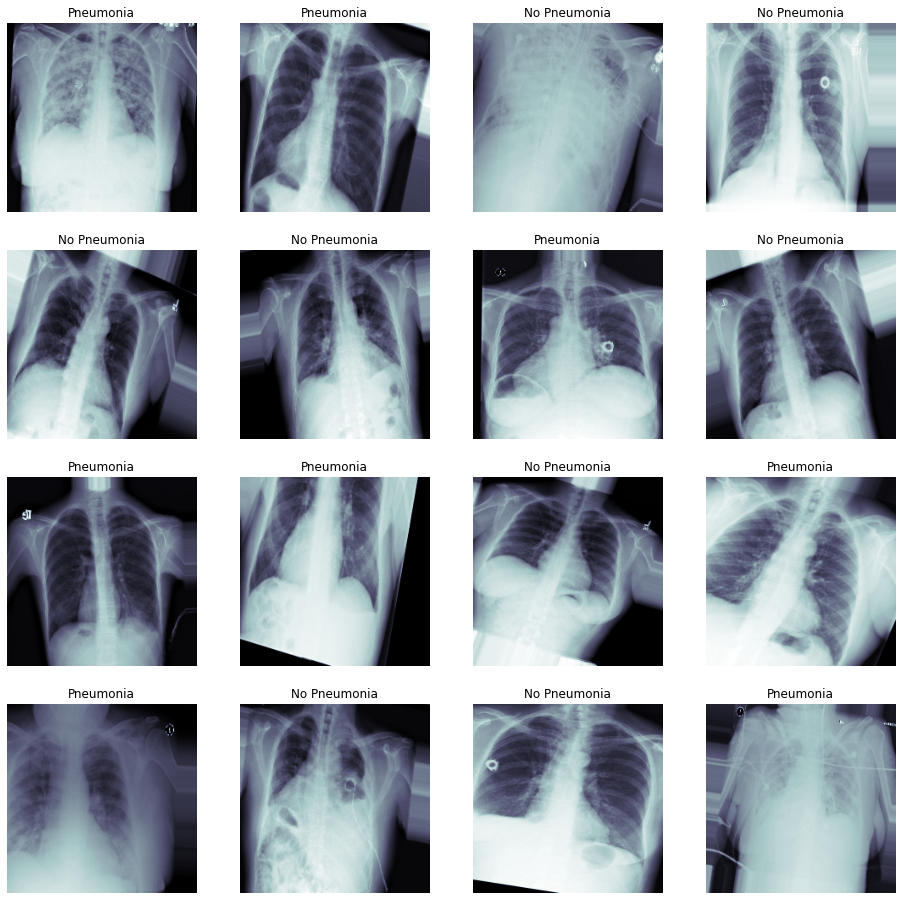

In [23]:
## look at some examples of our augmented training data. 
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


## Build model 


In [24]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [25]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [26]:
def build_my_model():  
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
        print(layer.name, layer.trainable)
    
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
     
    return my_model


In [27]:
my_model = build_my_model()
my_model.summary()

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
drop

In [28]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [29]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [30]:
## add checkpoints to model
weight_path="{}_my_model.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss' , 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=5)


callbacks_list = [checkpoint, early]


## Training

In [31]:
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10 , 
                          callbacks = callbacks_list)

Epoch 1/10
144/144 [==============================] - 67s 463ms/step - loss: 0.8534 - binary_accuracy: 0.5035 - val_loss: 0.8023 - val_binary_accuracy: 0.1875

Epoch 00001: val_loss improved from inf to 0.80232, saving model to pneumonia_class_my_model.best.hdf5
Epoch 2/10
144/144 [==============================] - 60s 417ms/step - loss: 0.7169 - binary_accuracy: 0.5358 - val_loss: 0.7295 - val_binary_accuracy: 0.3516

Epoch 00002: val_loss improved from 0.80232 to 0.72955, saving model to pneumonia_class_my_model.best.hdf5
Epoch 3/10
144/144 [==============================] - 60s 417ms/step - loss: 0.7015 - binary_accuracy: 0.5380 - val_loss: 0.7089 - val_binary_accuracy: 0.4688

Epoch 00003: val_loss improved from 0.72955 to 0.70891, saving model to pneumonia_class_my_model.best.hdf5
Epoch 4/10
144/144 [==============================] - 60s 418ms/step - loss: 0.6994 - binary_accuracy: 0.5345 - val_loss: 0.6730 - val_binary_accuracy: 0.5156

Epoch 00004: val_loss improved from 0.70891

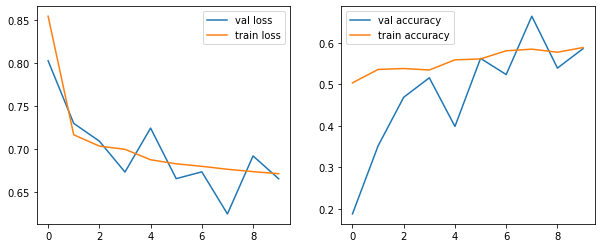

In [32]:
fig = plt.figure()
fig.set_figwidth(10)
fig.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.legend()

plt.show()

## Check the performance of the model by plotting some performance statistics


In [33]:
## assess the model's overall performance
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 128, verbose = True)


128/128 [==============================] - 10s 78ms/step


In [34]:
# valX, valY = val_gen.next()
#predicted output
prediction = pred_Y.reshape(-1) 
#groundtruth
label= valY.reshape(-1) 

In [35]:
# create a dataframe with groundtruth and predicted output
performances = pd.DataFrame({'ground_truth': label, 'probability': prediction})
performances.sample(5)

,ground_truth,probability
24,0.0,0.422612
97,0.0,0.533705
59,0.0,0.396281
47,1.0,0.629509
7,0.0,0.656020


In [36]:
def plot_roc_curve(ground_truth, probability):
    fig, ax = plt.subplots(1,1, figsize=(9,9))
    fp, tp, thresholds = roc_curve(ground_truth, probability)
    ax.plot(fp, tp, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fp, tp)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    pass

def plot_precision_recall_curve(ground_truth, probability):
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
    ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(ground_truth, probability)))
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    pass

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_history(history):
    plt.figure()
    N = len(history.history['loss'])
    plt.style.use('ggplot')
    plt.plot(np.arange(0,N), history.history['loss'],label='train_loss')
    plt.plot(np.arange(0,N), history.history['val_loss'],label='val_loss')
    plt.plot(np.arange(0,N), history.history['binary_accuracy'],label='train_accuracy')
    plt.plot(np.arange(0,N), history.history['val_binary_accuracy'],label='val_accuracy')
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

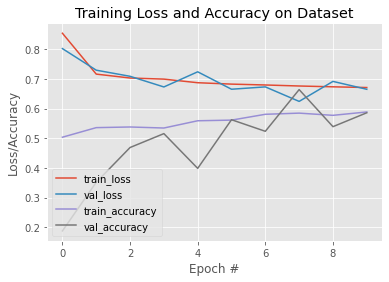

In [37]:
## plot figures
plot_history(history)

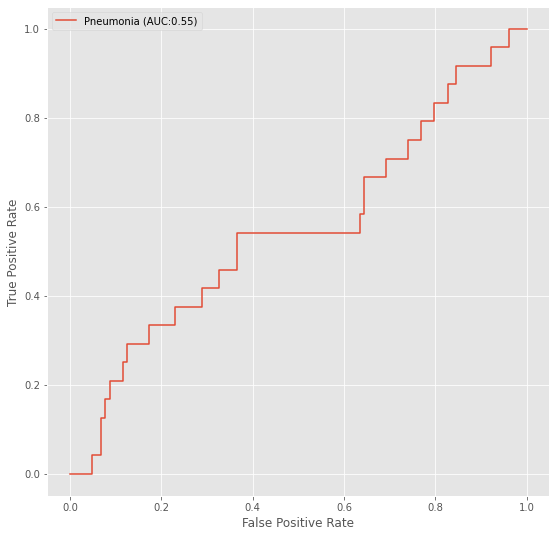

In [38]:
plot_roc_curve(performances['ground_truth'],performances['probability'])

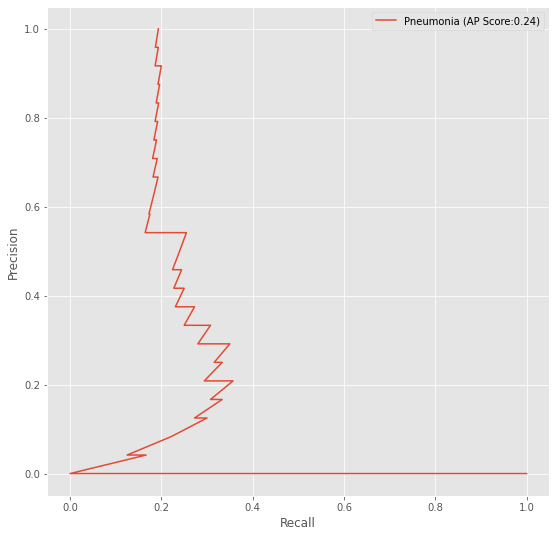

In [39]:
plot_precision_recall_curve(performances['ground_truth'],performances['probability'])

In [40]:
precision, recall, thresholds = precision_recall_curve(performances['ground_truth'],performances['probability'])

In [41]:
# use those two threshold values above to calculate the accuracy
probs = performances['probability']
t1 = (probs > 0.79)
t2 = (probs > 0.39)
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)
compare_t1 = (t1 == performances['ground_truth'])
compare_t2 = (t2 == performances['ground_truth'])

In [42]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(performances)))

Accuracy at threshold 1: 0.8125


In [43]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(performances)))

Accuracy at threshold 2: 0.4296875


Text(0.5, 1.0, 'The value of Precision/Recall with different threshold')

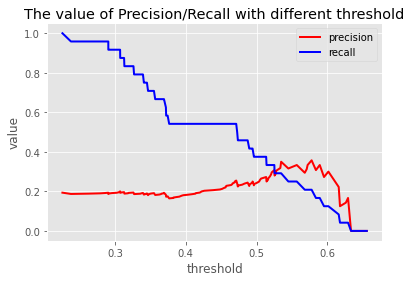

In [44]:
plt.plot(thresholds, precision[:-1], color='red', lw=2, label='precision')
plt.plot(thresholds, recall[:-1], color='blue', lw=2, label='recall')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('value')
plt.title('The value of Precision/Recall with different threshold')

According to the diagramm above it can be seen that the value of precision is always at a very low level. So it's better for us to choose a threshold that can get a high recall with a very small loss of precision.

In [45]:
# select a threshold
threshold = 0.3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


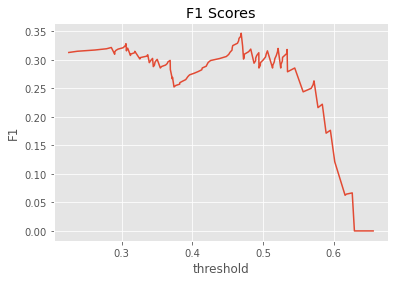

In [46]:
def f1(threshold):
    for num, val in enumerate(thresholds):
        if val > threshold:
            f1_score = calc_f1(precision[num], recall[num])
            if not math.isnan(f1_score):
                return f1_score
            else: 
                return 0
    return 0

f1_scores = [f1(val) for val in thresholds]
plt.plot(thresholds, f1_scores)
plt.title('F1 Scores')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.show()

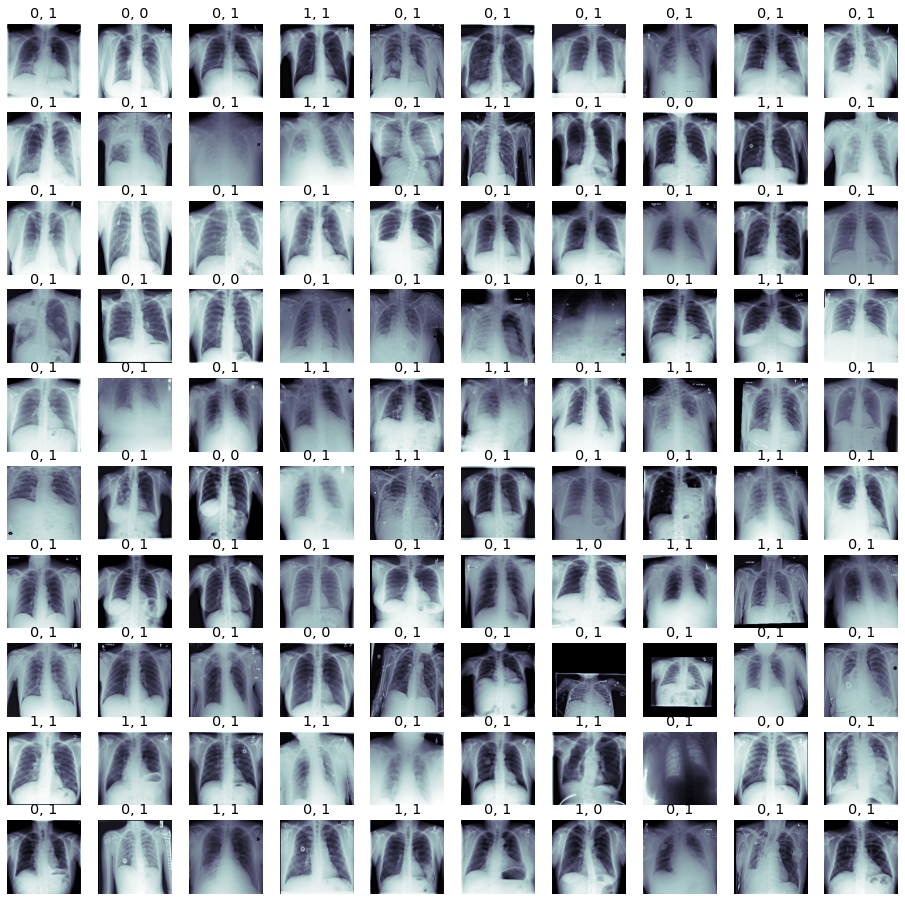

In [47]:
testY=valY
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [48]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)